# Classification of the anemia by conjunctiva

In [59]:
%cd '/content/drive/MyDrive/Anemia-Detection-From-Conjunctiva'

/content/drive/MyDrive/Anemia-Detection-From-Conjunctiva


In [62]:
!git config --global user.email "Shashankkapoor1994@gmail.com"
!git config --global user.name "Shashank Kapoor"

In [ ]:
!git add .

In [ ]:
!git commit -m "Added Files"

In [88]:
!git push origin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [ ]:
import os
import random
import numpy as np

dir_path = r"/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Detecting Iron Deficiency Anemia Using  conjunctiva  image Dataset"
Data_files = []
for file_path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, file_path)):
        Data_files.append(file_path)

In [ ]:
print(len(Data_files))

4272


#### Resize image

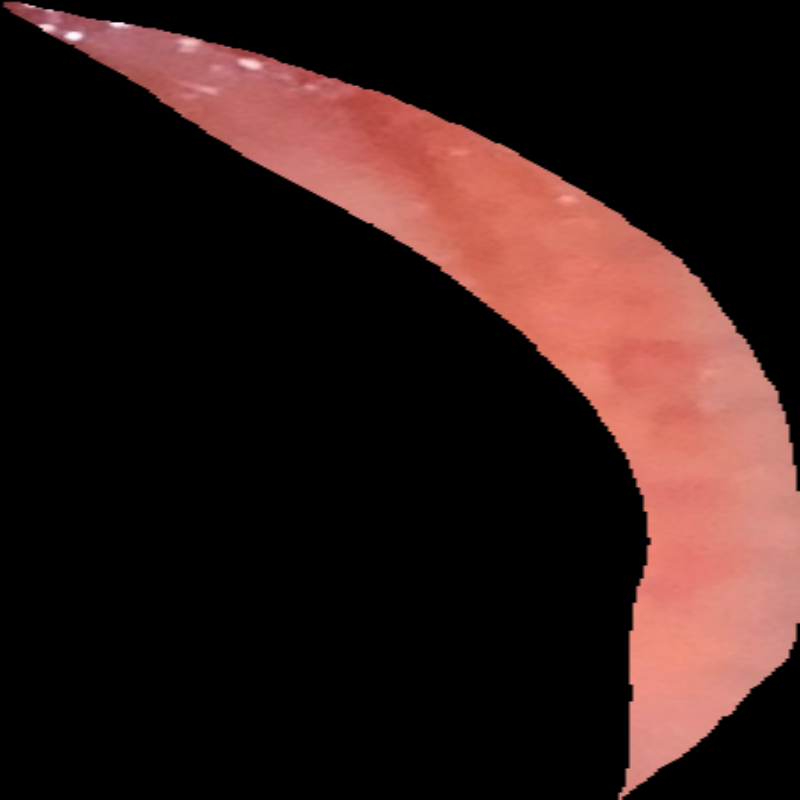

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Detecting Iron Deficiency Anemia Using  conjunctiva  image Dataset/Anemic-001 (10).png')

new_width = 800
new_height = 800
resized_image = cv2.resize(image, (new_width, new_height))

cv2_imshow(resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Finding the maximum image shape

In [ ]:
dataset=[]
dir_path = r"/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Detecting Iron Deficiency Anemia Using  conjunctiva  image Dataset"
max=0

for images in Data_files:
    img=np.array(cv2.imread(os.path.join(dir_path, images)))
    dataset.append(img)
    if(img.shape[0]>max or img.shape[1]>max):
      if img.shape[0] >img.shape[1] :
        max=img.shape[0]
        files=images
      else:
        max=img.shape[1]
        files=images
print(max)
print(files)
print(np.array(cv2.imread(os.path.join(dir_path, files))).shape)

513
Non-Anemic-202 (4).png
(513, 160, 3)


#### Resizing (padding)

In [ ]:
import math
from skimage.io import imsave, imread

for images in Data_files:
    img=np.array(cv2.imread(os.path.join(dir_path, images)))
    #print(img.shape)
    padding = ((math.floor((max-img.shape[0])/2), math.ceil((max-img.shape[0])/2)), (math.floor((max-img.shape[1])/2), math.ceil((max-img.shape[1])/2)),(0,0))
    y = np.pad(img, padding, mode='constant',constant_values=0)
    #print(y.shape)
    padded_image = y[:, :, [2, 1, 0]]
    imsave("/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Preprocessing_conjunctiva"+"/"+images,padded_image)

#### Step 1

In [ ]:
import os
import random
import numpy as np
import cv2

dir_path = r"/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Low_size_preprocessing_conjunctiva"
dataset = []
files_folder=[]
for file_path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, file_path)):
        img=np.array(cv2.imread(os.path.join(dir_path, file_path)))
        #img=img/255
        dataset.append(img)
        files_folder.append(file_path)


dataset=np.array(dataset)
print(dataset.shape)

labels=[]
for files in files_folder:
  if files[0] == 'N':
    labels.append(0)
  elif files[0] == 'A':
    labels.append(1)

labels=np.array(labels)
print(labels)

<ipython-input-2-b04159a4144c>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset=np.array(dataset).reshape(4272,-1,3)


ValueError: ignored

In [ ]:
import pickle

pickle.dump(dataset, open('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/x_normalized_conjunctiva.pkl', 'wb'))
pickle.dump(labels, open('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/y_normalized_conjunctiva.pkl', 'wb'))

# Data loading

In [89]:
import pickle

dataset = pickle.load(open('/content/drive/MyDrive/Anemia-Detection-From-Conjunctiva/x_final_conjunctiva.pkl', 'rb'))
labels = pickle.load(open('/content/drive/MyDrive/Anemia-Detection-From-Conjunctiva/y_final_conjunctiva.pkl', 'rb'))

In [90]:
print(dataset.shape)
print(len(labels))

(4272, 64, 64, 3)
4272


# Data Split

In [94]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset,  labels, test_size=0.30, random_state=42)

# x_train=x_train/255
# x_test=x_test/255


# Model Network

# EfficientnetV2B0

In [95]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

my_callbacks = [EarlyStopping(monitor='loss', patience=5)]

num_classes=2

# Load pre-trained EfficientNetB0 model without the classification head
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(64,64, 3))

for layer in base_model.layers:
    layer.trainable = True

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# Defining the optimizer
optimizer = Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)

# Compile the model
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#Model training
history=model.fit(x=x_train,y=y_train, batch_size=32, epochs=50000, verbose="auto",validation_split=0.2,callbacks=my_callbacks)

#Saving model
#model.save("/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva",save_format='efficientnet_model.h5') # not working with efficientnetB0

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 2, 2, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_11 (Dense)            (None, 2)                 2050      
                                                                 
Total params: 8,282,706
Trainable params: 8,222,098
No

In [96]:
model.save_weights('/content/drive/MyDrive/Anemia-Detection-From-Conjunctiva/EfficientNet_Experiment_2/Model/efficientnet_model.h5', overwrite=True, save_format='h5', options=None)

In [97]:
pickle.dump(history, open('/content/drive/MyDrive/Anemia-Detection-From-Conjunctiva/EfficientNet_Experiment_2/Result/efficientnet_history.pkl', 'wb'))

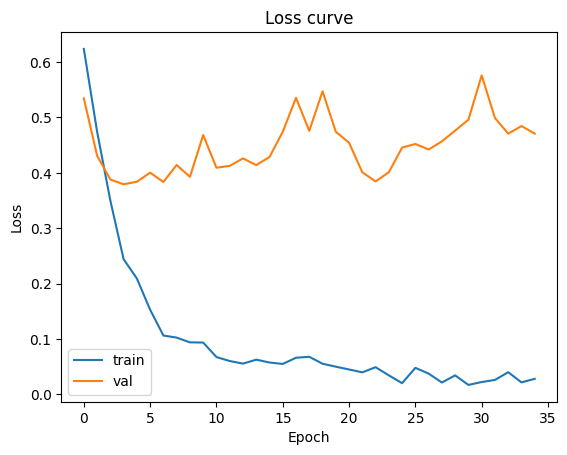

In [101]:
import matplotlib.pyplot as plt
history = pickle.load(open('/content/drive/MyDrive/Anemia-Detection-From-Conjunctiva/EfficientNet_Experiment_2/Result/efficientnet_history.pkl', 'rb'))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'])
plt.savefig("/content/drive/MyDrive/Anemia-Detection-From-Conjunctiva/EfficientNet_Experiment_2/Result/Loss_curve.png")
plt.show()


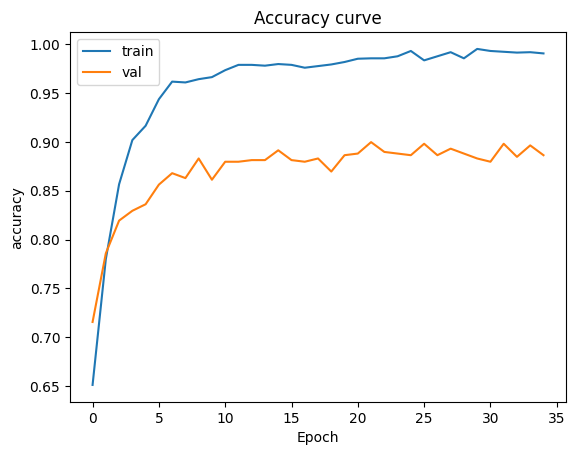

In [102]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.savefig("/content/drive/MyDrive/Anemia-Detection-From-Conjunctiva/EfficientNet_Experiment_2/Result/accuracy_curve.png")
plt.show()



In [103]:
model.load_weights('/content/drive/MyDrive/Anemia-Detection-From-Conjunctiva/EfficientNet_Experiment_2/Model/efficientnet_model.h5', skip_mismatch=False, by_name=False, options=None)

## Prediction

In [104]:
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

41/41 [==============================] - 4s 96ms/step - loss: 0.4546 - accuracy: 0.8994
test loss, test acc: [0.4546482563018799, 0.8993759751319885]


In [105]:
prediction = model.predict(x_test)

41/41 [==============================] - 6s 111ms/step


## Confusion Matrix

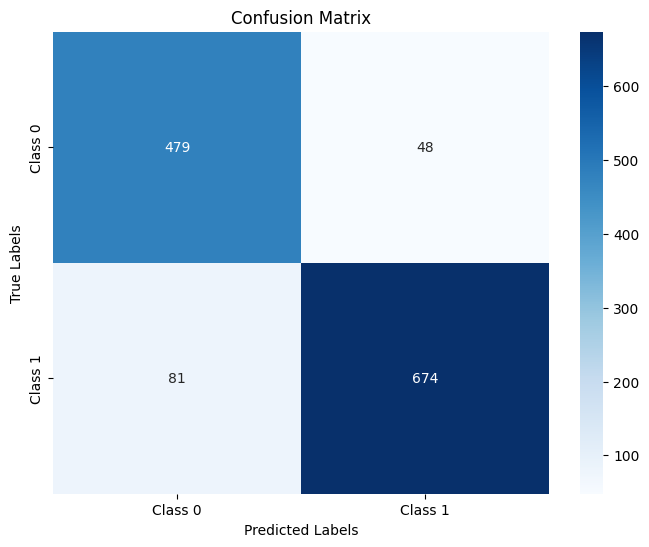

In [106]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predicted_classes = np.argmax(prediction, axis=1)

confusion_mat = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig("/content/drive/MyDrive/Anemia-Detection-From-Conjunctiva/EfficientNet_Experiment_2/Result/confusion_matrix.png") #save as png
plt.show()

# AlexNet Model


In [ ]:

from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import EarlyStopping

my_callbacks = [EarlyStopping(monitor='loss', patience=2)]

Alexnet=Sequential()
Alexnet.add(Conv2D(filters=128, kernel_size=(1,12), strides=(1,6), activation='relu', input_shape=(1,37158,3)))
Alexnet.add(BatchNormalization())
Alexnet.add(MaxPooling2D(pool_size=(1,2)))
Alexnet.add(Conv2D(filters=256, kernel_size=(1,6), strides=(1,2), activation='relu', padding="same"))
Alexnet.add(BatchNormalization())
Alexnet.add(MaxPooling2D(pool_size=(1,2)))
Alexnet.add(Conv2D(filters=256, kernel_size=(1,3), strides=(1,1), activation='relu', padding="same"))
Alexnet.add(BatchNormalization())
Alexnet.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))
Alexnet.add(BatchNormalization())
Alexnet.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))
Alexnet.add(BatchNormalization())
Alexnet.add(MaxPooling2D(pool_size=(1,2)))
Alexnet.add(Flatten())
Alexnet.add(Dense(1024,activation='relu'))
Alexnet.add(Dropout(0.5))
Alexnet.add(Dense(1024,activation='relu'))
Alexnet.add(Dropout(0.5))
Alexnet.add(Dense(2,activation='softmax'))
Alexnet.summary()

Alexnet.load_weights('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet_model.h5', skip_mismatch=False, by_name=False, options=None)

optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)

# Compile the model
Alexnet.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#Model training
history=Alexnet.fit(x=x_train,y=y_train, batch_size=32, epochs=50000, verbose="auto", callbacks=my_callbacks)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 1, 6192, 128)      4736      
                                                                 
 batch_normalization_5 (Batc  (None, 1, 6192, 128)     512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 3096, 128)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1548, 256)      196864    
                                                                 
 batch_normalization_6 (Batc  (None, 1, 1548, 256)     1024      
 hNormalization)                                                 
                                                      

In [ ]:
Alexnet.save_weights('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet_model.h5', overwrite=True, save_format='h5', options=None)

In [ ]:
pickle.dump(history, open('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet_history.pkl', 'wb'))

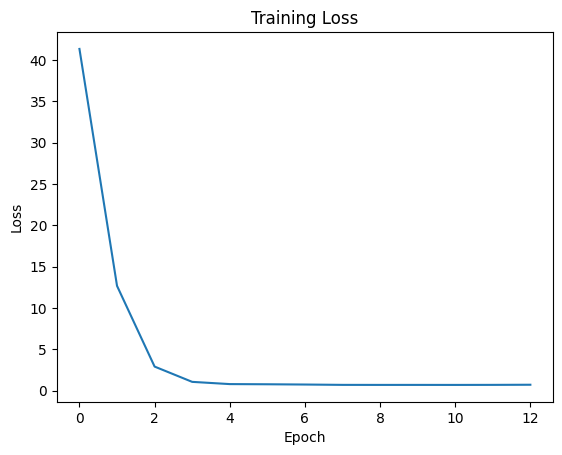

In [ ]:
import matplotlib.pyplot as plt
history = pickle.load(open('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet_history.pkl', 'rb'))

plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet_Loss_curve.png")
plt.show()

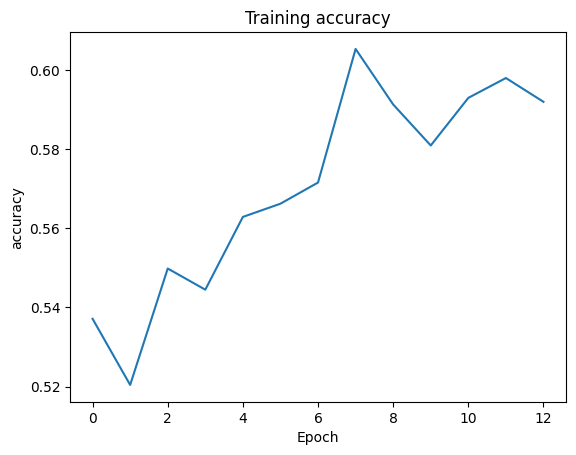

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.savefig("/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet_accuracy_curve.png")
plt.show()


In [ ]:
Alexnet.load_weights('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet_model.h5', skip_mismatch=False, by_name=False, options=None)

## Prediction

In [ ]:
results = Alexnet.evaluate(x_test, y_test)
print("test loss, test acc:", results)

41/41 [==============================] - 61s 1s/step - loss: 0.6688 - accuracy: 0.5913
test loss, test acc: [0.6687870025634766, 0.5912636518478394]


In [ ]:
prediction = Alexnet.predict(x_test)

41/41 [==============================] - 47s 1s/step


## Confusion matrix

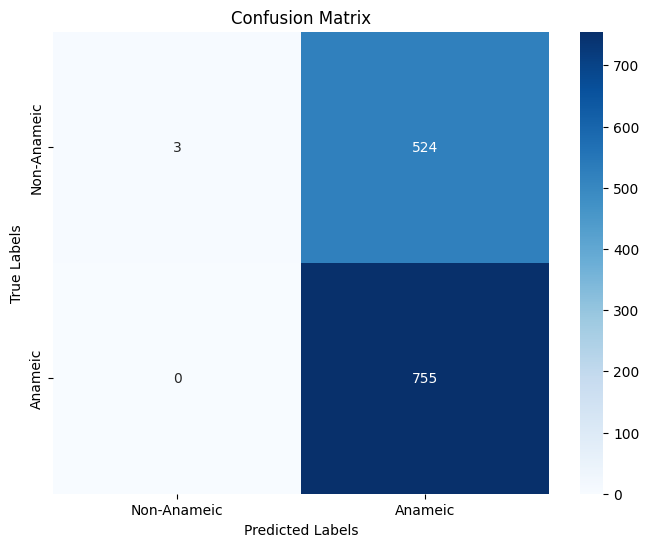

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predicted_classes = np.argmax(prediction, axis=1)

confusion_mat = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Anameic", "Anameic"], yticklabels=["Non-Anameic", "Anameic"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig("/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet_confusion_matrix.png") #save as png
plt.show()

# AlexNet Model_2


In [ ]:

from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import EarlyStopping

my_callbacks = [EarlyStopping(monitor='loss', patience=5)]

Alexnet=Sequential()
Alexnet.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)))
Alexnet.add(BatchNormalization())
Alexnet.add(MaxPooling2D(pool_size=(2,2)))
Alexnet.add(Conv2D(filters=128 , kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
Alexnet.add(BatchNormalization())
Alexnet.add(MaxPooling2D(pool_size=(2,2)))
Alexnet.add(Conv2D(filters=128 , kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
Alexnet.add(BatchNormalization())
Alexnet.add(Conv2D(filters=128 , kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
Alexnet.add(BatchNormalization())
Alexnet.add(Conv2D(filters=128 , kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
Alexnet.add(BatchNormalization())
Alexnet.add(MaxPooling2D(pool_size=(2,2)))
Alexnet.add(Flatten())
Alexnet.add(Dense(1024,activation='relu'))
Alexnet.add(Dropout(0.4))
Alexnet.add(Dense(1024,activation='relu'))
Alexnet.add(Dropout(0.4))
Alexnet.add(Dense(2,activation='softmax'))
Alexnet.summary()

#Alexnet.load_weights('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet_model.h5', skip_mismatch=False, by_name=False, options=None)

optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)

# Compile the model
Alexnet.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#Model training
history=Alexnet.fit(x=x_train,y=y_train, batch_size=32, epochs=50000, verbose="auto", callbacks=my_callbacks)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         307328    
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                        

In [ ]:
Alexnet.save_weights('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet3_model.h5', overwrite=True, save_format='h5', options=None)

In [ ]:
pickle.dump(history, open('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet3_history.pkl', 'wb'))

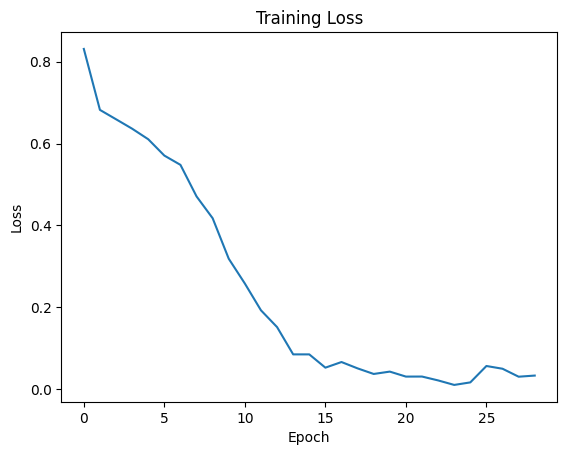

In [ ]:
import matplotlib.pyplot as plt
#history = pickle.load(open('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet3_history.pkl', 'rb'))

plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet3_Loss_curve.png")
plt.show()

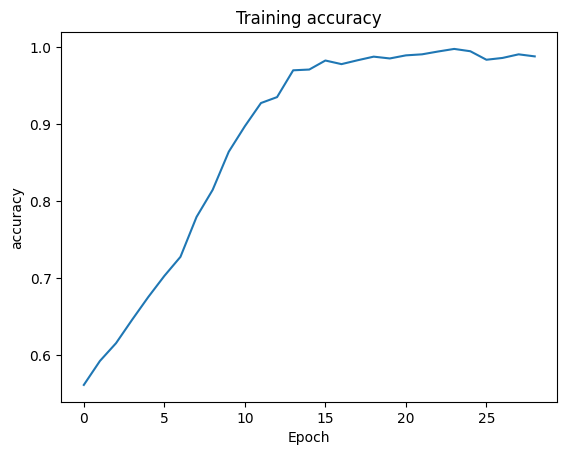

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.savefig("/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet3_accuracy_curve.png")
plt.show()


In [ ]:
Alexnet.load_weights('/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet3_model.h5', skip_mismatch=False, by_name=False, options=None)

## Prediction

In [ ]:
results = Alexnet.evaluate(x_test, y_test)
print("test loss, test acc:", results)

41/41 [==============================] - 3s 59ms/step - loss: 0.8421 - accuracy: 0.8814
test loss, test acc: [0.8421383500099182, 0.8814352750778198]


In [ ]:
prediction = Alexnet.predict(x_test)

41/41 [==============================] - 3s 54ms/step


## Confusion matrix

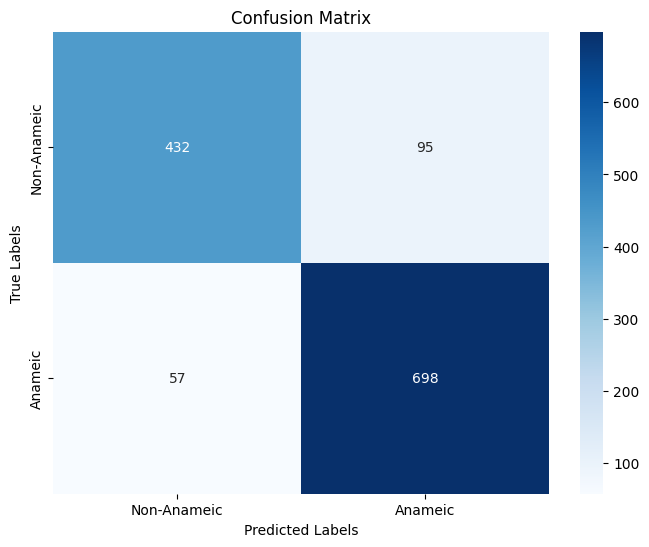

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predicted_classes = np.argmax(prediction, axis=1)

confusion_mat = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Anameic", "Anameic"], yticklabels=["Non-Anameic", "Anameic"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig("/content/drive/MyDrive/Classification of Anemia using palm and conjuntiva/Alexnet3_confusion_matrix.png") #save as png
plt.show()